Coincident Index (Dynamic Factor Model)
Based on the statsmodels example: 
https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_dfm_coincident.html

In [1]:
# 1. Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader
from statsmodels.tsa.statespace.dynamic_factor import DynamicFactor
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as sm
import arviz as az
from pymc_extras.statespace.core.statespace import PyMCStateSpace
import pytensor.tensor as pt
import pymc as pm
import pytensor

In [2]:
# 2. Download the data
# Series: INDPRO, PAYEMS, MANEMP, and RRSFS
# Monthly data from 1959-01 to 2020-12
start = datetime.datetime(1979, 1, 1)
end = datetime.datetime(2014, 12, 31)

In [3]:
indprod = DataReader("IPMAN", "fred", start=start, end=end)
income = DataReader("W875RX1", "fred", start=start, end=end)
sales = DataReader("CMRMTSPL", "fred", start=start, end=end)
emp = DataReader("PAYEMS", "fred", start=start, end=end)

In [4]:
data = pd.concat((indprod, income, sales, emp), axis=1)
data.columns = ["indprod", "income", "sales", "emp"]
data.index.freq = data.index.inferred_freq

In [5]:
print(data.head())

            indprod  income       sales    emp
DATE                                          
1979-01-01  47.1722  5248.7  561382.192  88808
1979-02-01  47.3093  5278.5  558729.039  89055
1979-03-01  47.5389  5294.3  574897.892  89479
1979-04-01  46.7402  5242.7  559387.521  89417
1979-05-01  47.3949  5227.5  571771.305  89789


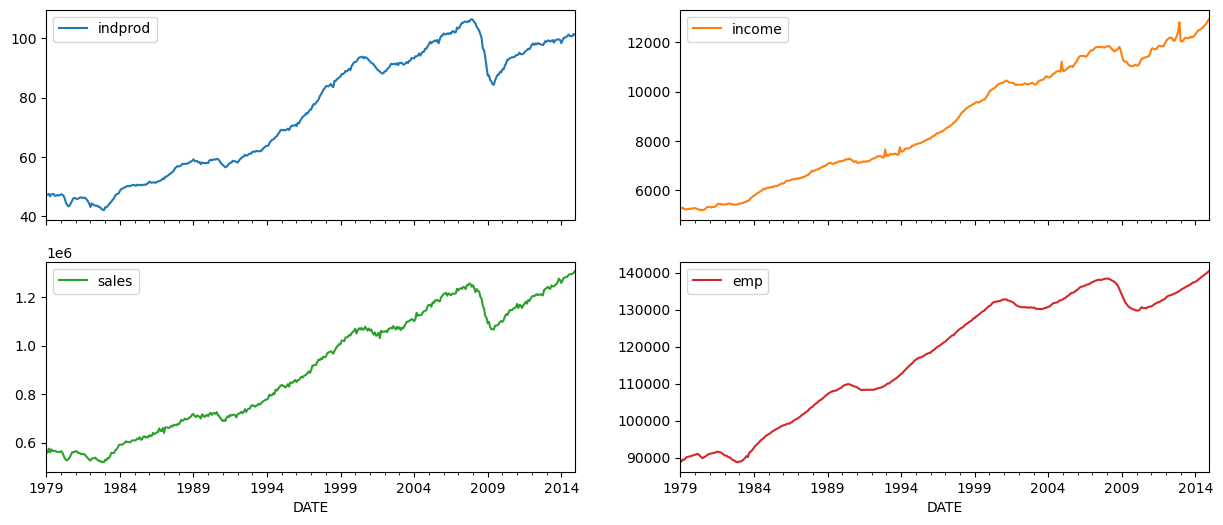

In [6]:
data.loc[:, "indprod":"emp"].plot(subplots=True, layout=(2, 2), figsize=(15, 6));

### Cointegration

In [7]:
def johansen_cointegration_test(df, det_order=-1, k_ar_diff=1):
    """
    Perform Johansen cointegration test
    det_order: Deterministic trend assumption (-1 to 3)
    k_ar_diff: Lag order for differencing (usually 1)
    """
    print("Johansen Cointegration Test Results")
    coint_test = coint_johansen(df.dropna(), det_order, k_ar_diff)

    trace_stat = coint_test.lr1
    crit_values = coint_test.cvt

    for i in range(len(trace_stat)):
        print(f"Rank {i}: Trace Statistic = {trace_stat[i]:.2f}, 90% CV = {crit_values[i, 0]:.2f}, 95% CV = {crit_values[i, 1]:.2f}, 99% CV = {crit_values[i, 2]:.2f}")
        if trace_stat[i] > crit_values[i, 1]:
            print("=> Reject H0: Cointegration rank >=", i)
        else:
            print("=> Fail to reject H0: Cointegration rank <", i)
        print()


In [8]:
coint_data = (data[['indprod', 'income', 'sales', 'emp']])
johansen_cointegration_test(coint_data)

Johansen Cointegration Test Results
Rank 0: Trace Statistic = 85.23, 90% CV = 37.03, 95% CV = 40.17, 99% CV = 46.57
=> Reject H0: Cointegration rank >= 0

Rank 1: Trace Statistic = 27.72, 90% CV = 21.78, 95% CV = 24.28, 99% CV = 29.51
=> Reject H0: Cointegration rank >= 1

Rank 2: Trace Statistic = 6.23, 90% CV = 10.47, 95% CV = 12.32, 99% CV = 16.36
=> Fail to reject H0: Cointegration rank < 2

Rank 3: Trace Statistic = 1.36, 90% CV = 2.98, 95% CV = 4.13, 99% CV = 6.94
=> Fail to reject H0: Cointegration rank < 3



The Johansen test indicates the presence of 2 cointegrating relationships among the 4 time series. This means there are 2 independent stationary linear combinations (cointegrating vectors). However, we will follow our reference, testing stationarity for each time series and eventually applying a tranformation.


### Stationarity

In [9]:
def adf_test(series, title=''):
    """
    Perform Augmented Dickey-Fuller test
    """
    print(f'ADF Test for {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# Observations']
    for value, label in zip(result[:4], labels):
        print(f"{label}: {value}")
    if result[1] <= 0.05:
        print("=> Stationary (reject H0)")
    else:
        print("=> Non-stationary (fail to reject H0)")
    print()


In [10]:

for col in ['indprod', 'income', 'sales', 'emp']:
    adf_test(data[col], title=col)
   

ADF Test for indprod
ADF Statistic: -0.6730347475672278
p-value: 0.8536110682655401
# Observations: 12
=> Non-stationary (fail to reject H0)

ADF Test for income
ADF Statistic: 0.0829843235392625
p-value: 0.9648799685690176
# Observations: 9
=> Non-stationary (fail to reject H0)

ADF Test for sales
ADF Statistic: -0.21492222758297064
p-value: 0.936719395568298
# Observations: 12
=> Non-stationary (fail to reject H0)

ADF Test for emp
ADF Statistic: -0.9032661691141197
p-value: 0.7868949183862891
# Observations: 3
=> Non-stationary (fail to reject H0)



In [11]:
# Create log-differenced series
data["dln_indprod"] = (np.log(data.indprod)).diff() * 100
data["dln_income"] = (np.log(data.income)).diff() * 100
data["dln_sales"] = (np.log(data.sales)).diff() * 100
data["dln_emp"] = (np.log(data.emp)).diff() * 100

# De-mean and standardize
data["std_indprod"] = (data["dln_indprod"] - data["dln_indprod"].mean()) / data[
    "dln_indprod"
].std()
data["std_income"] = (data["dln_income"] - data["dln_income"].mean()) / data[
    "dln_income"
].std()
data["std_sales"] = (data["dln_sales"] - data["dln_sales"].mean()) / data["dln_sales"].std()
data["std_emp"] = (data["dln_emp"] - data["dln_emp"].mean()) / data["dln_emp"].std()

In [12]:
# Get the endogenous data
endog = data.loc["1979-02-01":, "std_indprod":"std_emp"]

In [13]:
for col in ["std_indprod","std_income", "std_sales", "std_emp"]:
    adf_test(endog[col], title=col)

ADF Test for std_indprod
ADF Statistic: -7.3337173809532725
p-value: 1.1105668612348205e-10
# Observations: 2
=> Stationary (reject H0)

ADF Test for std_income
ADF Statistic: -4.455094080898953
p-value: 0.0002368322834477289
# Observations: 13
=> Stationary (reject H0)

ADF Test for std_sales
ADF Statistic: -8.827935086435593
p-value: 1.8022396062717108e-14
# Observations: 2
=> Stationary (reject H0)

ADF Test for std_emp
ADF Statistic: -4.175631871435514
p-value: 0.0007243551568346825
# Observations: 2
=> Stationary (reject H0)



As the reference notebook stated reporting the findings of the paper Stock and Watson (1991), we are able to reach stationarity after taking as transformation the first differences (of the logs).

In [14]:
print(endog.head())

            std_indprod  std_income  std_sales   std_emp
DATE                                                    
1979-02-01     0.144369    0.536870  -0.722874  0.897660
1979-03-01     0.392176    0.134841   2.867766  1.929842
1979-04-01    -2.391601   -1.787951  -3.163686 -0.918544
1979-05-01     1.550990   -0.751468   2.151995  1.616819
1979-06-01    -0.067774   -0.076092  -1.319191  1.300121


## Statsmodel

In [42]:
# 4. Fit the Dynamic Factor Model
mod = DynamicFactor(endog, k_factors=1, factor_order=2, error_order=2)
initial_res = mod.fit(method="powell", disp=False)
res = mod.fit(disp=False)
print(res.summary())

                                             Statespace Model Results                                            
Dep. Variable:     ['std_indprod', 'std_income', 'std_sales', 'std_emp']   No. Observations:                  431
Model:                                 DynamicFactor(factors=1, order=2)   Log Likelihood               -2050.756
                                                          + AR(2) errors   AIC                           4137.513
Date:                                                   Wed, 02 Jul 2025   BIC                           4210.703
Time:                                                           10:47:30   HQIC                          4166.410
Sample:                                                       02-01-1979                                         
                                                            - 12-01-2014                                         
Covariance Type:                                                     opg                

/opt/anaconda3/envs/pymc_extras_env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


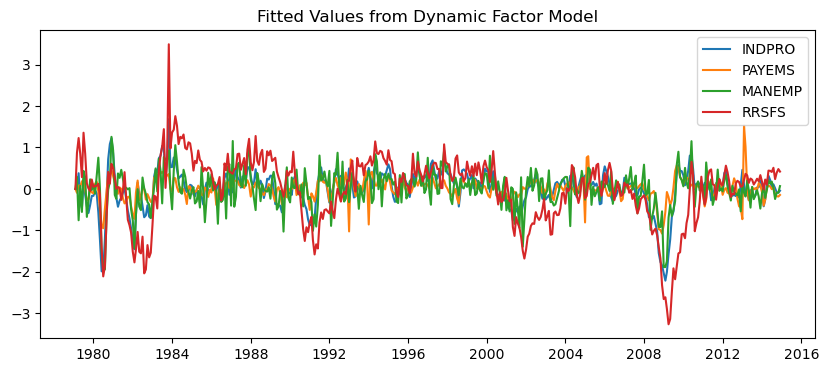

In [43]:
# 5. Plot the estimated factor
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(res.fittedvalues.index, res.fittedvalues.iloc[:, 0], label='INDPRO')
ax.plot(res.fittedvalues.index, res.fittedvalues.iloc[:, 1], label='PAYEMS')
ax.plot(res.fittedvalues.index, res.fittedvalues.iloc[:, 2], label='MANEMP')
ax.plot(res.fittedvalues.index, res.fittedvalues.iloc[:, 3], label='RRSFS')
ax.legend()
ax.set(title='Fitted Values from Dynamic Factor Model')
plt.show()

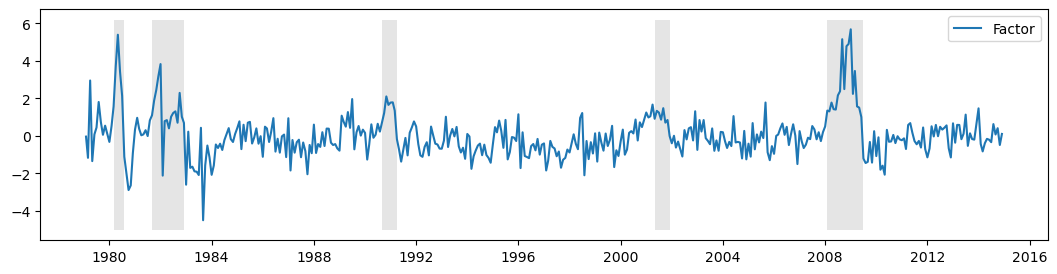

In [44]:
fig, ax = plt.subplots(figsize=(13, 3))

# Plot the factor
dates = endog.index._mpl_repr()
ax.plot(dates, res.factors.filtered[0], label="Factor")
ax.legend()

# Retrieve and also plot the NBER recession indicators
rec = DataReader("USREC", "fred", start=start, end=end)
ylim = ax.get_ylim()
ax.fill_between(
    dates[:-3], ylim[0], ylim[1], rec.values[:-4, 0], facecolor="k", alpha=0.1
);

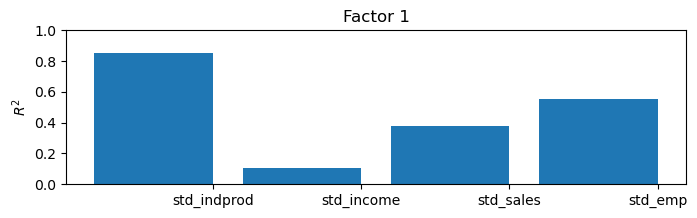

In [45]:
res.plot_coefficients_of_determination(figsize=(8, 2));

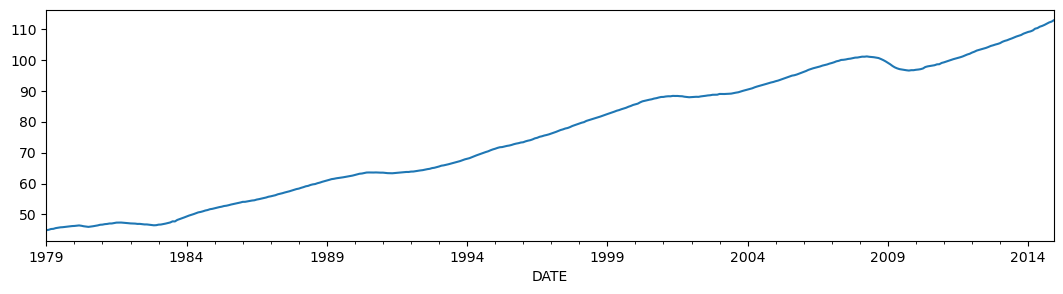

In [46]:
usphci = DataReader("USPHCI", "fred", start=start, end=end)["USPHCI"]
usphci.plot(figsize=(13, 3));

In [47]:
dusphci = usphci.diff()[1:].values

def compute_coincident_index(mod, res):
    # Estimate W(1)
    spec = res.specification
    design = mod.ssm["design"]
    transition = mod.ssm["transition"]
    ss_kalman_gain = res.filter_results.kalman_gain[:, :, -1]

    k_states = ss_kalman_gain.shape[0]

    W1 = np.linalg.inv(
        np.eye(k_states)
        - np.dot(np.eye(k_states) - np.dot(ss_kalman_gain, design), transition)
    ).dot(ss_kalman_gain)[0]

    # Compute the factor mean vector
    factor_mean = np.dot(W1, data.loc[start:, "dln_indprod":"dln_emp"].mean())

    # Normalize the factors
    factor = res.factors.filtered[0].copy()

    factor *= np.std(usphci.diff()[1:]) / np.std(factor)

    # Compute the coincident index
    coincident_index = np.zeros(mod.nobs + 1)
    # The initial value is arbitrary; here it is set to
    # facilitate comparison
    coincident_index[0] = usphci.iloc[0] * factor_mean / dusphci.mean()
    for t in range(0, mod.nobs):
        coincident_index[t + 1] = coincident_index[t] + factor[t] + factor_mean

    # Attach dates
    coincident_index = pd.Series(coincident_index, index=data.index).iloc[1:]

    # Normalize to use the same base year as USPHCI
    coincident_index *= usphci.loc["1992-07-01"] / coincident_index.loc["1992-07-01"]

    return coincident_index, factor

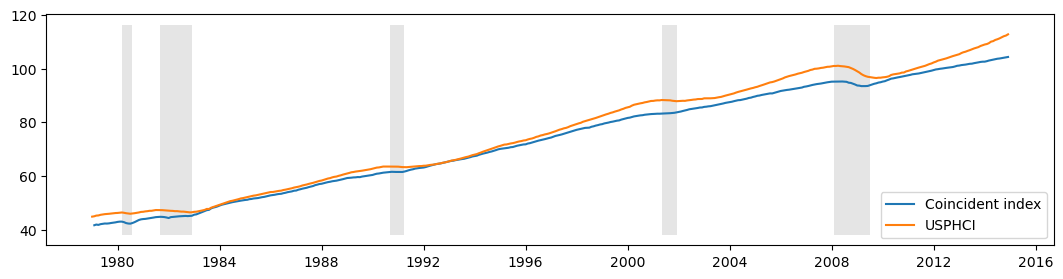

In [48]:
fig, ax = plt.subplots(figsize=(13, 3))

# Compute the index
coincident_index, factor = compute_coincident_index(mod, res)

# Plot the factor
dates = endog.index._mpl_repr()
ax.plot(dates, coincident_index, label="Coincident index")
ax.plot(usphci.index._mpl_repr(), usphci, label="USPHCI")
ax.legend(loc="lower right")

# Retrieve and also plot the NBER recession indicators
ylim = ax.get_ylim()
ax.fill_between(
    dates[:-3], ylim[0], ylim[1], rec.values[:-4, 0], facecolor="k", alpha=0.1
);

## PyMC

In [24]:
matrix_names = [
    "initial_state",
    "initial_state_cov",
    "state_intercept",
    "obs_intercept",
    "transition",
    "design",
    "selection",
    "obs_cov",
    "state_cov",
]


def print_model_ssm(mod, how="eval"):
    nice_heading = f'{"name":<20}{"__repr__":<50}{"shape":<10}{"value":<20}'
    print(nice_heading)
    print("=" * len(nice_heading))
    if how == "eval":
        matrices = [x.eval() for x in mod._unpack_statespace_with_placeholders()]
    elif how == "draw":
        matrices = pm.draw(mod.unpack_statespace())

    for name, value in zip(matrix_names, matrices):
        repr_ = str(mod.ssm[name])
        shape = str(mod.ssm[name].type.shape)
        value = str(value).replace("\n ", "\n" + " " * 81)
        print(f"{name:<20}{repr_:<50}{shape:<10}{value:<20}")
        print("-" * len(nice_heading))

In [25]:
class DFM_dummy(PyMCStateSpace):
    def __init__(self):
        k_states = 10  # 2 for factor + 2*4 for error terms
        k_posdef = 5   # 1 for factor shock + 4 for individual AR error shocks
        k_endog = 4

        super().__init__(k_endog=k_endog, k_states=k_states, k_posdef=k_posdef)

    def make_symbolic_graph(self):
        x0 = self.make_and_register_variable("x0", shape=(10,))
        P0 = self.make_and_register_variable("P0", shape=(10, 10))

        # Loadings λ_i
        lambdas = [self.make_and_register_variable(f"lambda_{i+1}", shape=()) for i in range(4)]

        # AR(2) coeffs for the factor
        ar1 = self.make_and_register_variable("ar1", shape=())
        ar2 = self.make_and_register_variable("ar2", shape=())
        sigma_f = self.make_and_register_variable("sigma_f", shape=())

        # AR(2) coeffs and std dev for each u_{i,t}
        c = []
        sigmas = []
        for i in range(4):
            c1 = self.make_and_register_variable(f"c{i+1}_1", shape=())
            c2 = self.make_and_register_variable(f"c{i+1}_2", shape=())
            sigma_u = self.make_and_register_variable(f"sigma_u{i+1}", shape=())
            c.append((c1, c2))
            sigmas.append(sigma_u)

        # Design matrix
        self.ssm["design", :, :] = 0.0
        for i in range(4):
            self.ssm["design", i, 0] = lambdas[i]   # load on factor
            self.ssm["design", i, 2*i+2] = 1.0       # load on u_{i,t}

        # Transition matrix (AR(2) for factor and for each u_i,t)
        self.ssm["transition", :, :] = 0.0
        self.ssm["transition", 0, 0] = ar1
        self.ssm["transition", 0, 1] = ar2
        self.ssm["transition", 1, 0] = 1.0

        for i in range(4):
            pos = 2*i + 2
            c1, c2 = c[i]
            self.ssm["transition", pos, pos] = c1
            self.ssm["transition", pos, pos+1] = c2
            self.ssm["transition", pos+1, pos] = 1.0

        # Selection matrix: noise affects only first state of each AR(2)
        self.ssm["selection", :, :] = 0.0
        self.ssm["selection", 0, 0] = 1.0  # factor noise
        for i in range(4):
            self.ssm["selection", 2*i+2, i+1] = 1.0  # u_i,t noise

        # State covariance Q
        self.ssm["state_cov", :, :] = 0.0
        self.ssm["state_cov", 0, 0] = sigma_f
        for i in range(4):
            self.ssm["state_cov", i+1, i+1] = sigmas[i]

        self.ssm["obs_cov", :, :] = pt.diag(pt.constant(np.ones(4)))

        # Initial conditions
        self.ssm["initial_state", :] = x0
        self.ssm["initial_state_cov", :, :] = P0

    @property
    def param_names(self):
        names = ["x0", "P0", "ar1", "ar2", "sigma_f"]
        for i in range(4):
            names.extend([f"lambda_{i+1}", f"c{i+1}_1", f"c{i+1}_2", f"sigma_u{i+1}"])
        return names


In [ ]:
dfm = DFM_dummy()

with pm.Model() as pymc_mod:
    # Initial state mean and covariance for full 10D state vector
    x0 = pm.Deterministic("x0", pt.zeros(10))
    P0 = pm.Deterministic("P0", pt.eye(10))

    # Factor loadings
    lambda_1 = pm.HalfNormal("lambda_1", sigma=1.0) # to have same loadings sign in each chain
    lambda_2 = pm.Normal("lambda_2", sigma=1.0)
    lambda_3 = pm.Normal("lambda_3", sigma=1.0)
    lambda_4 = pm.Normal("lambda_4", sigma=1.0)

    # AR(2) coefficients for factor f_t
    ar1 = pm.Normal("ar1", sigma=0.5)
    ar2 = pm.Normal("ar2", sigma=0.5)

    sigma_f = pm.Deterministic("sigma_f", pt.constant(1.0, dtype=float))

    # AR(2) coefficients and noise stds for the 4 error terms u_{i,t}
    for i in range(1, 5):  # i = 1 to 4
        pm.Normal(f"c{i}_1", sigma=0.5)
        pm.Normal(f"c{i}_2", sigma=0.5)
        pm.HalfNormal(f"sigma_u{i}", sigma=1.0)

    # Build symbolic graph
    dfm.build_statespace_graph(data=endog, mode="JAX")


In [27]:
print_model_ssm(dfm, "draw")

name                __repr__                                          shape     value               
initial_state       initial_state                                     (10,)     [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
----------------------------------------------------------------------------------------------------
initial_state_cov   initial_state_cov                                 (10, 10)  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
                                                                                 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
                                                                                 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
                                                                                 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
                                                                                 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
                                                                                 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
        

In [ ]:
dfm = DFM_dummy()

with pm.Model() as pymc_mod:
    # Initial state mean and covariance for full 10D state vector
    x0 = pm.Deterministic("x0", pt.zeros(10))
    P0 = pm.Deterministic("P0", pt.eye(10))

    # Factor loadings
    lambda_1 = pm.HalfNormal("lambda_1", sigma=1.0) # to have same loadings sign in each chain
    lambda_2 = pm.Normal("lambda_2", sigma=1.0)
    lambda_3 = pm.Normal("lambda_3", sigma=1.0)
    lambda_4 = pm.Normal("lambda_4", sigma=1.0)

    # AR(2) coefficients for factor f_t
    ar1 = pm.Normal("ar1", sigma=0.5)
    ar2 = pm.Normal("ar2", sigma=0.5)

    sigma_f = pm.Deterministic("sigma_f", pt.constant(1.0, dtype=float))

    # AR(2) coefficients and noise stds for the 4 error terms u_{i,t}
    for i in range(1, 5):  # i = 1 to 4
        pm.Normal(f"c{i}_1", sigma=0.5)
        pm.Normal(f"c{i}_2", sigma=0.5)
        pm.HalfNormal(f"sigma_u{i}", sigma=1.0)

    # Build symbolic graph
    dfm.build_statespace_graph(data=endog, mode="JAX")
    idata = pm.sample(
        draws=1000,
        chains=4,
        nuts_sampler="nutpie",
        nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"},
    )

idata.to_netcdf("SampleNutpie4ChainsHalfNormal.nc")

KeyboardInterrupt: 

In [28]:
idata = az.from_netcdf("SampleNutpie2.nc")

<Axes: >

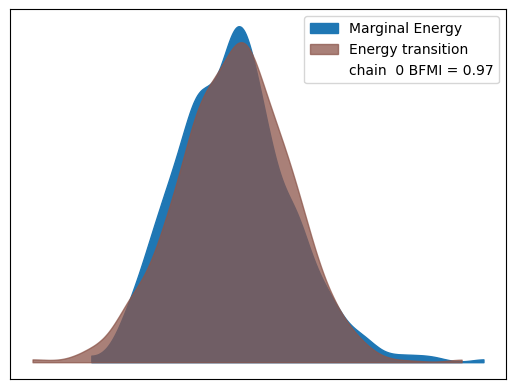

In [29]:
az.plot_energy(idata)

In [30]:
var_names_list = [
        "ar1", "ar2",
        "lambda_1", "lambda_2", "lambda_3", "lambda_4",
        "c1_1", "c1_2", "sigma_u1",
        "c2_1", "c2_2", "sigma_u2",
        "c3_1", "c3_2", "sigma_u3",
        "c4_1", "c4_2", "sigma_u4"
    ]

array([[<Axes: title={'center': 'ar1'}>, <Axes: title={'center': 'ar1'}>],
       [<Axes: title={'center': 'ar2'}>, <Axes: title={'center': 'ar2'}>],
       [<Axes: title={'center': 'lambda_1'}>,
        <Axes: title={'center': 'lambda_1'}>],
       [<Axes: title={'center': 'lambda_2'}>,
        <Axes: title={'center': 'lambda_2'}>],
       [<Axes: title={'center': 'lambda_3'}>,
        <Axes: title={'center': 'lambda_3'}>],
       [<Axes: title={'center': 'lambda_4'}>,
        <Axes: title={'center': 'lambda_4'}>],
       [<Axes: title={'center': 'c1_1'}>,
        <Axes: title={'center': 'c1_1'}>],
       [<Axes: title={'center': 'c1_2'}>,
        <Axes: title={'center': 'c1_2'}>],
       [<Axes: title={'center': 'sigma_u1'}>,
        <Axes: title={'center': 'sigma_u1'}>],
       [<Axes: title={'center': 'c2_1'}>,
        <Axes: title={'center': 'c2_1'}>],
       [<Axes: title={'center': 'c2_2'}>,
        <Axes: title={'center': 'c2_2'}>],
       [<Axes: title={'center': 'sigma_u2'}>,

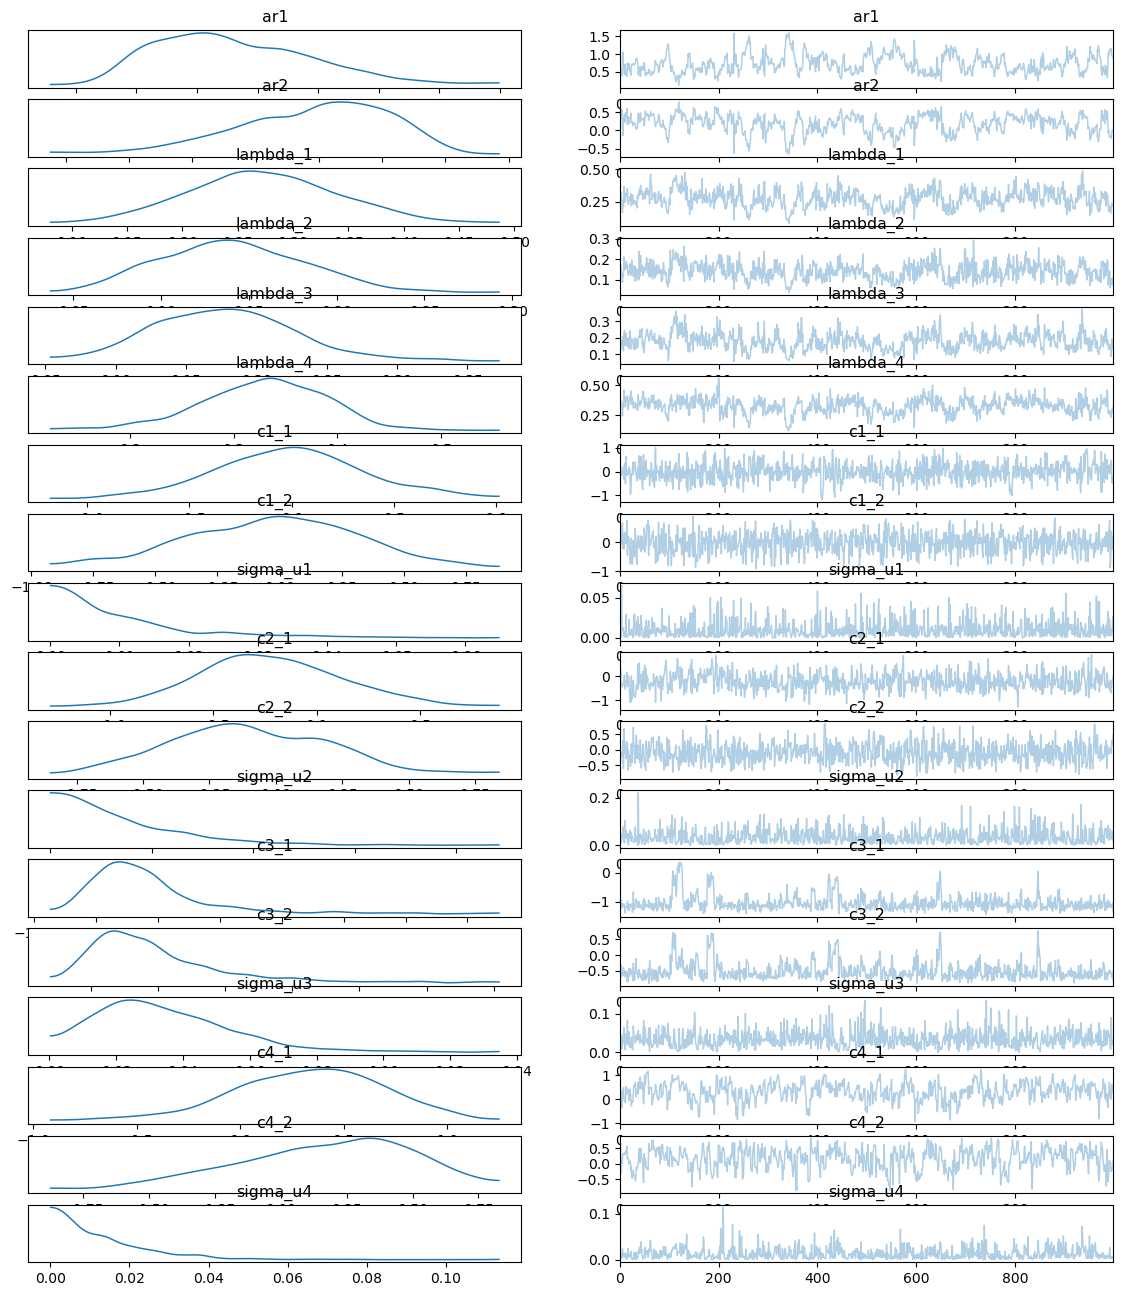

In [31]:
az.plot_trace(
    idata,
    var_names=var_names_list,
    figsize=(14, 16),
    compact=False
)

array([[<Axes: title={'center': 'ar1'}>, <Axes: title={'center': 'ar2'}>,
        <Axes: title={'center': 'lambda_1'}>],
       [<Axes: title={'center': 'lambda_2'}>,
        <Axes: title={'center': 'lambda_3'}>,
        <Axes: title={'center': 'lambda_4'}>],
       [<Axes: title={'center': 'c1_1'}>,
        <Axes: title={'center': 'c1_2'}>,
        <Axes: title={'center': 'sigma_u1'}>],
       [<Axes: title={'center': 'c2_1'}>,
        <Axes: title={'center': 'c2_2'}>,
        <Axes: title={'center': 'sigma_u2'}>],
       [<Axes: title={'center': 'c3_1'}>,
        <Axes: title={'center': 'c3_2'}>,
        <Axes: title={'center': 'sigma_u3'}>],
       [<Axes: title={'center': 'c4_1'}>,
        <Axes: title={'center': 'c4_2'}>,
        <Axes: title={'center': 'sigma_u4'}>]], dtype=object)

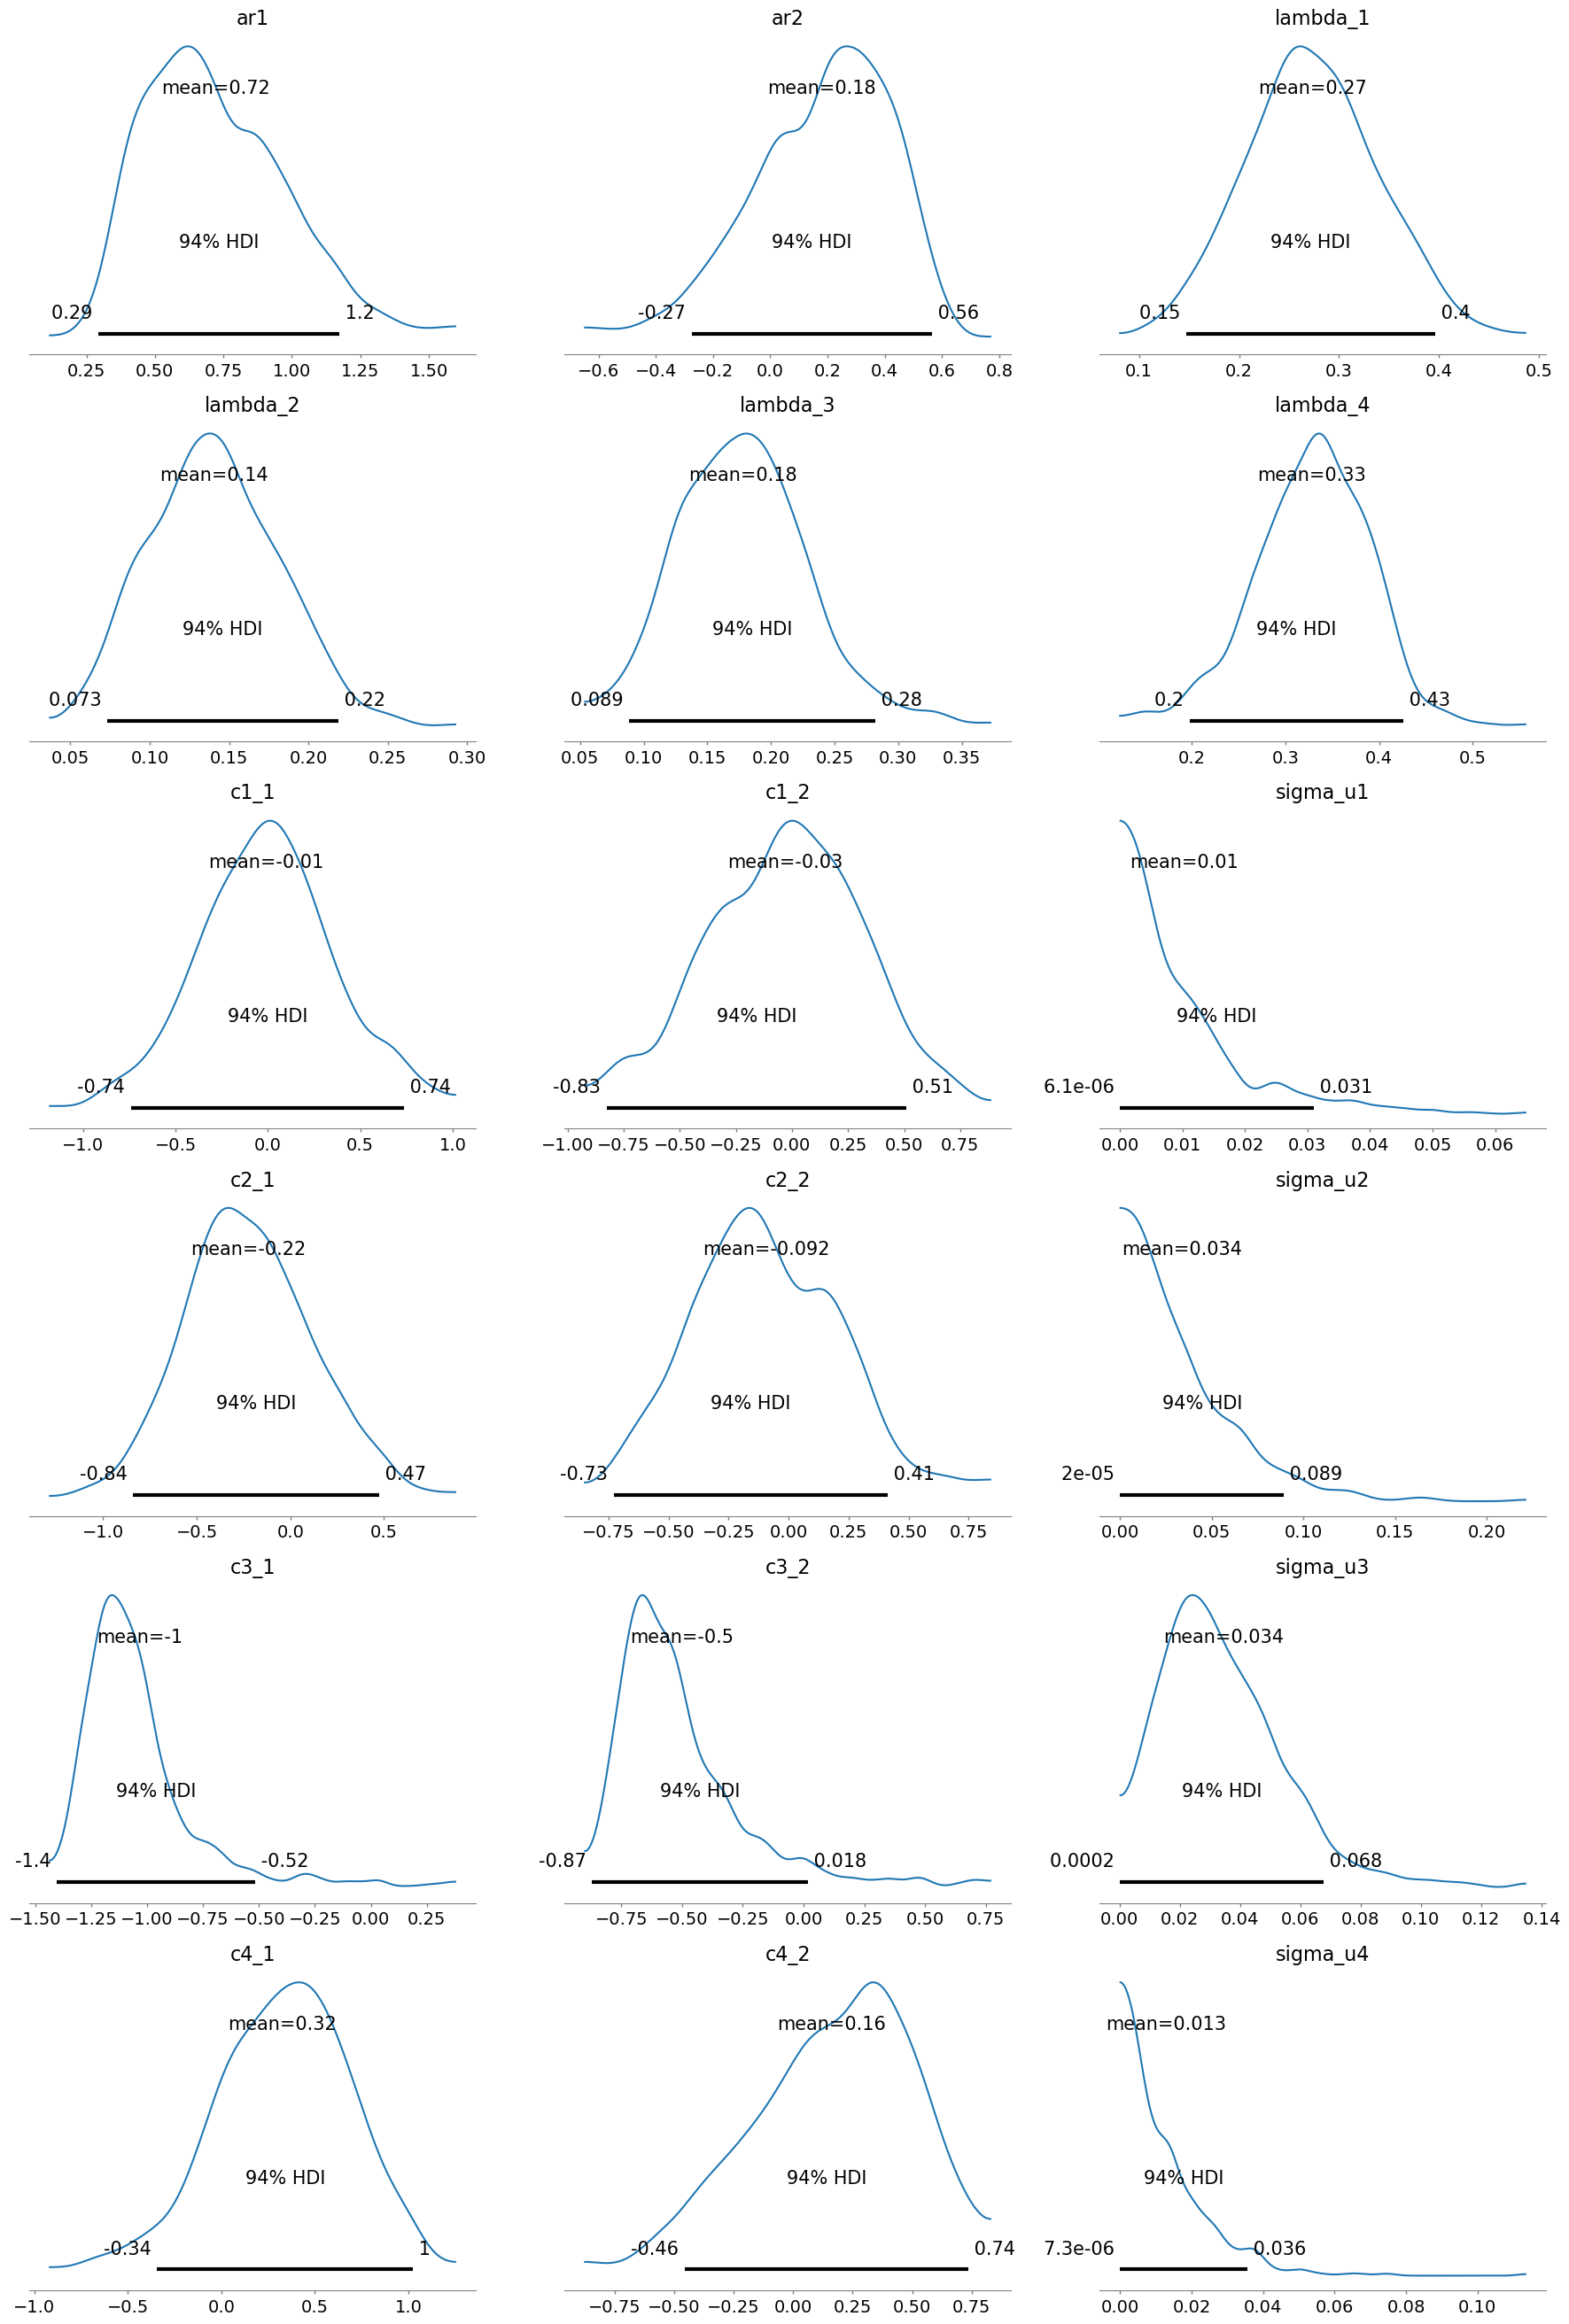

In [32]:
az.plot_posterior(
    idata,
    var_names=var_names_list  
)

In [34]:
with pm.Model() as index_mod:
    dfm._build_dummy_graph()
    dfm._insert_random_variables()
    x0, P0, C, D, T, Z, R, H, Q = matrices = dfm.unpack_statespace()

    dfm.build_statespace_graph(data=endog, mode="JAX", save_kalman_filter_outputs_in_idata=True)
    predicted_covariance = index_mod["predicted_covariance"]
    filtered_state = index_mod["filtered_state"]

    # attention to the order
    
    def step(P, Z, T, H):
        PZT = pt.dot(P, Z.T)
        F = Z.dot(PZT) + H + pt.eye(H.shape[0]) * 1e-6

        # K = pt.linalg.solve(F, pt.dot(T, PZT).T, assume_a="pos", check_finite=False).T   
        K = pt.linalg.solve(F, PZT.T, assume_a="pos", check_finite=False).T
        return K

    ss_kalman_gain, updates = pytensor.scan(step, non_sequences=[Z, T, H], 
                                           sequences=[predicted_covariance])
    
    ss_kalman_gain = ss_kalman_gain[-1] # Get the last Kalman gain (steady state)

    k_states = T.shape[0]
    W1 = pt.linalg.inv(
        pt.eye(k_states)
        - pt.dot(pt.eye(k_states) - pt.dot(ss_kalman_gain, Z), T)
    ).dot(ss_kalman_gain)[0]

    # Compute the factor mean vector
    factor_mean = pt.dot(W1, data.loc[start:, "dln_indprod":"dln_emp"].mean())

    pm.Deterministic("factor_mean", factor_mean)
    factor_mean_idata=pm.sample_posterior_predictive(idata, var_names=["factor_mean"])
    filtered_state_idata = pm.sample_posterior_predictive(idata, var_names=["filtered_state"])

    

Sampling: []


Output()

Sampling: []


Output()

In [35]:
def compute_coincident_index_pymc(factor_mean_idata, filtered_state_idata):

    # Extract posterior predictive samples
    factor_samples = factor_mean_idata.posterior_predictive["factor_mean"].values 
    factor_0_mean = factor_samples.mean(axis=(0, 1))  
    factor_mean = factor_0_mean

    # Extract posterior predictive samples
    state_samples = filtered_state_idata.posterior_predictive["filtered_state"].values  
    state_0_samples = state_samples[:, :, :, 0]  
    state_0_mean = state_0_samples.mean(axis=(0, 1))  


    # Normalize the states
    state_0_mean *= np.std(usphci.diff()[1:]) / np.std(state_0_mean)


    # Compute the coincident index
    coincident_index = np.zeros(state_0_mean.shape[0] + 1)
    # The initial value is arbitrary; here it is set to
    # facilitate comparison
    coincident_index[0] = usphci.iloc[0] * factor_mean / dusphci.mean()
    for t in range(0, state_0_mean.shape[0]):
        coincident_index[t + 1] = coincident_index[t] + state_0_mean[t] + factor_mean

    # Attach dates
    coincident_index = pd.Series(coincident_index, index=data.index).iloc[1:]

    # Normalize to use the same base year as USPHCI
    coincident_index *= usphci.loc["1992-07-01"] / coincident_index.loc["1992-07-01"]

    return coincident_index

Coincident index shape: (431,)


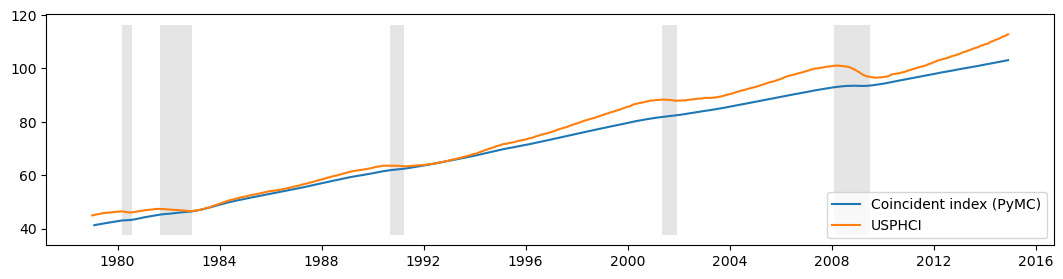

In [36]:
fig, ax = plt.subplots(figsize=(13, 3))

# Compute the index
coincident_index_pymc = compute_coincident_index_pymc(factor_mean_idata, filtered_state_idata)

print("Coincident index shape:", coincident_index_pymc.shape)

# Plot the factor
dates = endog.index._mpl_repr()
ax.plot(dates, coincident_index_pymc, label="Coincident index (PyMC)")
ax.plot(usphci.index._mpl_repr(), usphci, label="USPHCI")
ax.legend(loc="lower right")

# Retrieve and also plot the NBER recession indicators
ylim = ax.get_ylim()
ax.fill_between(
    dates[:-3], ylim[0], ylim[1], rec.values[:-4, 0], facecolor="k", alpha=0.1
);

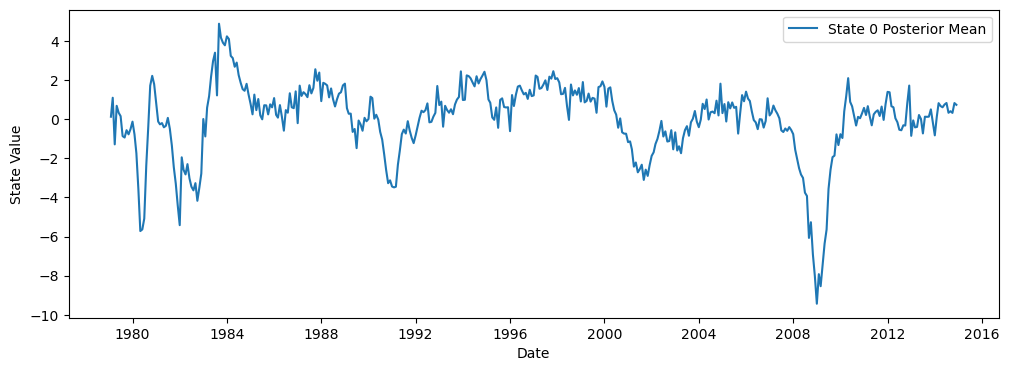

In [37]:
# Extract posterior predictive samples
state_samples = filtered_state_idata.posterior_predictive["filtered_state"].values  # shape: (2, 500, 10, 431)

# Select the first state (index 0)
state_0_samples = state_samples[:, :, :, 0]  # shape: (1, 1000, 431)

# Average over chains and draws to get posterior mean for each time point
state_0_mean = state_0_samples.mean(axis=(0, 1))  # shape: (431,)

# Get the time index from your observed data for x-axis
dates = filtered_state_idata.observed_data.time.values  # array of datetime64

# Plot
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(dates, state_0_mean, label="State 0 Posterior Mean")
ax.set_xlabel("Date")
ax.set_ylabel("State Value")
ax.legend()
plt.show()

lower = np.percentile(state_0_samples, 2.5, axis=(0, 1))
upper = np.percentile(state_0_samples, 97.5, axis=(0, 1))

ax.fill_between(dates, lower, upper, color='gray', alpha=0.3, label="95% CI")

## Comparison of PyMC and Stats

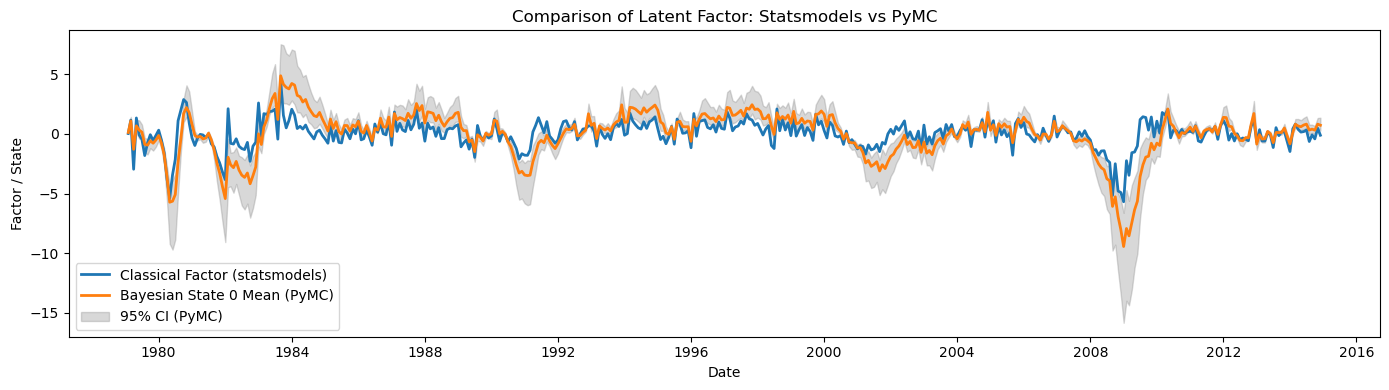

In [49]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(dates, -res.factors.filtered[0], label="Classical Factor (statsmodels)", linewidth=2)
ax.plot(dates, state_0_mean, label="Bayesian State 0 Mean (PyMC)", linewidth=2)
ax.fill_between(dates, lower, upper, color='gray', alpha=0.3, label="95% CI (PyMC)")
ax.legend()
ax.set_title("Comparison of Latent Factor: Statsmodels vs PyMC")
ax.set_xlabel("Date")
ax.set_ylabel("Factor / State")
plt.tight_layout()
plt.show()

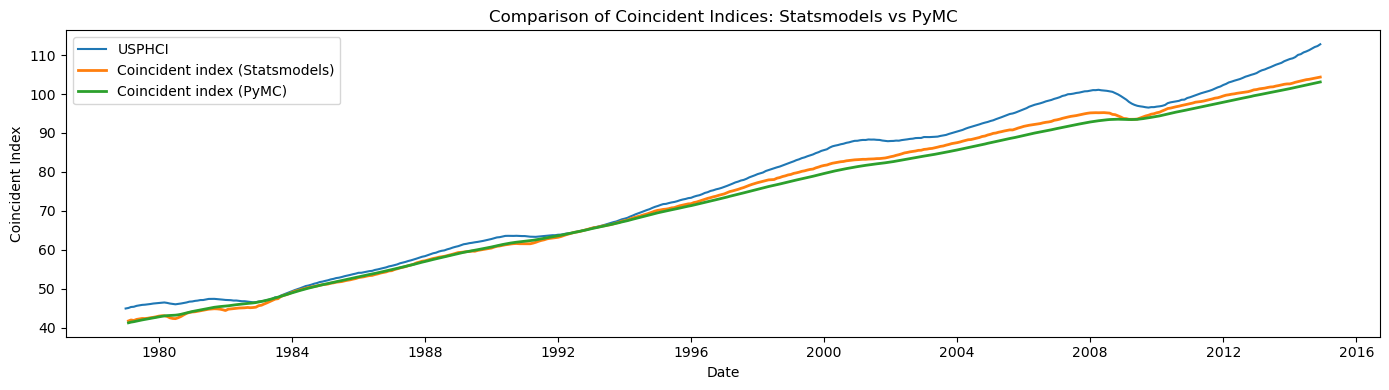

In [50]:

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(usphci.index._mpl_repr(), usphci, label="USPHCI")
ax.plot(dates, coincident_index, label="Coincident index (Statsmodels)", linewidth=2)
ax.plot(dates, coincident_index_pymc, label="Coincident index (PyMC)", linewidth=2)
ax.legend()
ax.set_title("Comparison of Coincident Indices: Statsmodels vs PyMC")
ax.set_xlabel("Date")
ax.set_ylabel("Coincident Index")
plt.tight_layout()
plt.show()

## Extended Stats model

In [51]:
from statsmodels.tsa.statespace import tools


class ExtendedDFM(sm.tsa.DynamicFactor):
    def __init__(self, endog, **kwargs):
        # Setup the model as if we had a factor order of 4
        super(ExtendedDFM, self).__init__(
            endog, k_factors=1, factor_order=4, error_order=2, **kwargs
        )

        # Note: `self.parameters` is an ordered dict with the
        # keys corresponding to parameter types, and the values
        # the number of parameters of that type.
        # Add the new parameters
        self.parameters["new_loadings"] = 3

        # Cache a slice for the location of the 4 factor AR
        # parameters (a_1, ..., a_4) in the full parameter vector
        offset = (
            self.parameters["factor_loadings"]
            + self.parameters["exog"]
            + self.parameters["error_cov"]
        )
        self._params_factor_ar = np.s_[offset : offset + 2]
        self._params_factor_zero = np.s_[offset + 2 : offset + 4]

    @property
    def start_params(self):
        # Add three new loading parameters to the end of the parameter
        # vector, initialized to zeros (for simplicity; they could
        # be initialized any way you like)
        return np.r_[super(ExtendedDFM, self).start_params, 0, 0, 0]

    @property
    def param_names(self):
        # Add the corresponding names for the new loading parameters
        #  (the name can be anything you like)
        return super(ExtendedDFM, self).param_names + [
            "loading.L%d.f1.%s" % (i, self.endog_names[3]) for i in range(1, 4)
        ]

    def transform_params(self, unconstrained):
        # Perform the typical DFM transformation (w/o the new parameters)
        constrained = super(ExtendedDFM, self).transform_params(unconstrained[:-3])

        # Redo the factor AR constraint, since we only want an AR(2),
        # and the previous constraint was for an AR(4)
        ar_params = unconstrained[self._params_factor_ar]
        constrained[self._params_factor_ar] = tools.constrain_stationary_univariate(
            ar_params
        )

        # Return all the parameters
        return np.r_[constrained, unconstrained[-3:]]

    def untransform_params(self, constrained):
        # Perform the typical DFM untransformation (w/o the new parameters)
        unconstrained = super(ExtendedDFM, self).untransform_params(constrained[:-3])

        # Redo the factor AR unconstrained, since we only want an AR(2),
        # and the previous unconstrained was for an AR(4)
        ar_params = constrained[self._params_factor_ar]
        unconstrained[self._params_factor_ar] = tools.unconstrain_stationary_univariate(
            ar_params
        )

        # Return all the parameters
        return np.r_[unconstrained, constrained[-3:]]

    def update(self, params, transformed=True, **kwargs):
        # Peform the transformation, if required
        if not transformed:
            params = self.transform_params(params)
        params[self._params_factor_zero] = 0

        # Now perform the usual DFM update, but exclude our new parameters
        super(ExtendedDFM, self).update(params[:-3], transformed=True, **kwargs)

        # Finally, set our new parameters in the design matrix
        self.ssm["design", 3, 1:4] = params[-3:]


In [52]:
# Create the model
extended_mod = ExtendedDFM(endog)
initial_extended_res = extended_mod.fit(maxiter=1000, disp=False)
extended_res = extended_mod.fit(initial_extended_res.params, method="nm", maxiter=1000)
print(extended_res.summary(separate_params=False))

                                             Statespace Model Results                                            
Dep. Variable:     ['std_indprod', 'std_income', 'std_sales', 'std_emp']   No. Observations:                  431
Model:                                 DynamicFactor(factors=1, order=4)   Log Likelihood               -2038.327
                                                          + AR(2) errors   AIC                           4122.654
Date:                                                   Wed, 02 Jul 2025   BIC                           4216.175
Time:                                                           10:47:55   HQIC                          4159.579
Sample:                                                       02-01-1979                                         
                                                            - 12-01-2014                                         
Covariance Type:                                                     opg                

/opt/anaconda3/envs/pymc_extras_env/lib/python3.10/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/opt/anaconda3/envs/pymc_extras_env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


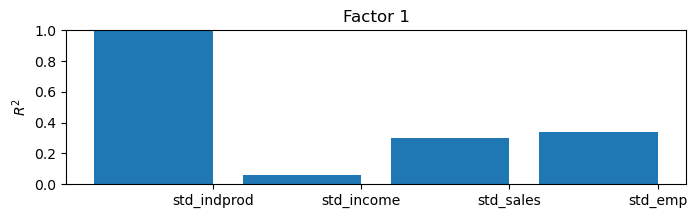

In [53]:
extended_res.plot_coefficients_of_determination(figsize=(8, 2));

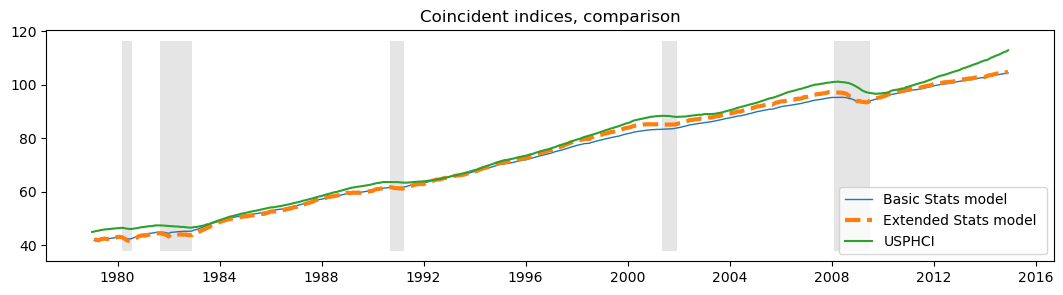

In [55]:
fig, ax = plt.subplots(figsize=(13, 3))

# Compute the index
extended_coincident_index, extended_factor = compute_coincident_index(extended_mod, extended_res)

# Plot the factor
dates = endog.index._mpl_repr()
ax.plot(dates, coincident_index, "-", linewidth=1, label="Basic Stats model")
ax.plot(dates, extended_coincident_index, "--", linewidth=3, label="Extended Stats model ")
ax.plot(usphci.index._mpl_repr(), usphci, label="USPHCI")
ax.legend(loc="lower right")
ax.set(title="Coincident indices, comparison")

# Retrieve and also plot the NBER recession indicators
ylim = ax.get_ylim()
ax.fill_between(
    dates[:-3], ylim[0], ylim[1], rec.values[:-4, 0], facecolor="k", alpha=0.1
);

## Extended PyMC

In [56]:
class Extended_DFM_dummy(PyMCStateSpace):
    def __init__(self):
        k_states = 12  # 2 for factor + 2*4 for error terms
        k_posdef = 5   # 1 for factor shock + 4 for individual AR error shocks
        k_endog = 4

        super().__init__(k_endog=k_endog, k_states=k_states, k_posdef=k_posdef)

    def make_symbolic_graph(self):
        x0 = self.make_and_register_variable("x0", shape=(self.k_states,))
        P0 = self.make_and_register_variable("P0", shape=(self.k_states, self.k_states))

        # Loadings λ_i
        lambdas = [self.make_and_register_variable(f"lambda_{i+1}", shape=()) for i in range(self.k_endog+3)]

        # AR(2) coeffs for the factor
        ar1 = self.make_and_register_variable("ar1", shape=())
        ar2 = self.make_and_register_variable("ar2", shape=())
        sigma_f = self.make_and_register_variable("sigma_f", shape=())

        # AR(2) coeffs and std dev for each u_{i,t}
        c = []
        sigmas = []
        for i in range(4):
            c1 = self.make_and_register_variable(f"c{i+1}_1", shape=())
            c2 = self.make_and_register_variable(f"c{i+1}_2", shape=())
            sigma_u = self.make_and_register_variable(f"sigma_u{i+1}", shape=())
            c.append((c1, c2))
            sigmas.append(sigma_u)

        # Design matrix
        self.ssm["design", :, :] = 0.0
        for i in range(4):
            self.ssm["design", i, 0] = lambdas[i]    # load on factor
            self.ssm["design", i, 2*i+4] = 1.0       # load on u_{i,t}

        for i in range(3):
            self.ssm["design", 3, i+1] = lambdas[i+4]

        # Transition matrix (AR(2) for factor and for each u_i,t)
        self.ssm["transition", :, :] = 0.0
        self.ssm["transition", 0, 0] = ar1
        self.ssm["transition", 0, 1] = ar2
        self.ssm["transition", 1, 0] = 1.0
        self.ssm["transition", 2, 1] = 1.0  
        self.ssm["transition", 3, 2] = 1.0  

        for i in range(4):
            pos = 2*i + 4
            c1, c2 = c[i]
            self.ssm["transition", pos, pos] = c1
            self.ssm["transition", pos, pos+1] = c2
            self.ssm["transition", pos+1, pos] = 1.0

        # Selection matrix: noise affects only first state of each AR(2)
        self.ssm["selection", :, :] = 0.0
        self.ssm["selection", 0, 0] = 1.0  # factor noise
        for i in range(4):
            self.ssm["selection", 2*i+2, i+1] = 1.0  # u_i,t noise

        # State covariance Q
        self.ssm["state_cov", :, :] = 0.0
        self.ssm["state_cov", 0, 0] = sigma_f
        for i in range(4):
            self.ssm["state_cov", i+1, i+1] = sigmas[i]

        self.ssm["obs_cov", :, :] = pt.diag(pt.constant(np.ones(4)))

        # Initial conditions
        self.ssm["initial_state", :] = x0
        self.ssm["initial_state_cov", :, :] = P0

    @property
    def param_names(self):
        names = ["x0", "P0", "ar1", "ar2", "sigma_f"]
        for i in range(4):
            names.extend([f"c{i+1}_1", f"c{i+1}_2", f"sigma_u{i+1}"])
        for i in range(7):
            names.extend([f"lambda_{i+1}"])
        return names

In [57]:
ext_coincident_dfm = Extended_DFM_dummy()

with pm.Model() as pymc_mod:
    # Initial state mean and covariance for full 10D state vector
    x0 = pm.Deterministic("x0", pt.zeros(12))
    P0 = pm.Deterministic("P0", pt.eye(12))

    # Factor loadings
    lambda_1 = pm.Normal("lambda_1", sigma=1.0)
    lambda_2 = pm.Normal("lambda_2", sigma=1.0)
    lambda_3 = pm.Normal("lambda_3", sigma=1.0)
    lambda_4 = pm.Normal("lambda_4", sigma=1.0)
    lambda_5 = pm.Normal("lambda_5", sigma=1.0)
    lambda_6 = pm.Normal("lambda_6", sigma=1.0)
    lambda_7 = pm.Normal("lambda_7", sigma=1.0)

    # AR(2) coefficients for factor f_t
    ar1 = pm.Normal("ar1", sigma=0.5)
    ar2 = pm.Normal("ar2", sigma=0.5)

    sigma_f = pm.Deterministic("sigma_f", pt.constant(1.0, dtype=float))

    # AR(2) coefficients and noise stds for the 4 error terms u_{i,t}
    for i in range(1, 5):  # i = 1 to 4
        pm.Normal(f"c{i}_1", sigma=0.5)
        pm.Normal(f"c{i}_2", sigma=0.5)
        pm.HalfNormal(f"sigma_u{i}", sigma=1.0)

    # Build symbolic graph
    ext_coincident_dfm.build_statespace_graph(data=endog, mode="JAX")

In [22]:
print_model_ssm(ext_coincident_dfm, "draw")

NameError: name 'print_model_ssm' is not defined

In [23]:
import pymc_extras as pmx

In [ ]:
ext_coincident_dfm  = Extended_DFM_dummy()

with pm.Model() as pymc_mod:
    # Initial state mean and covariance for full 12D state vector
    x0 = pm.Deterministic("x0", pt.zeros(12))
    P0 = pm.Deterministic("P0", pt.eye(12))

    # Factor loadings
    lambda_1 = pm.Normal("lambda_1", sigma=1.0)
    lambda_2 = pm.Normal("lambda_2", sigma=1.0)
    lambda_3 = pm.Normal("lambda_3", sigma=1.0)
    lambda_4 = pm.Normal("lambda_4", sigma=1.0)
    lambda_5 = pm.Normal("lambda_5", sigma=1.0)
    lambda_6 = pm.Normal("lambda_6", sigma=1.0)
    lambda_7 = pm.Normal("lambda_7", sigma=1.0)

    # AR(2) coefficients for factor f_t
    ar1 = pm.Normal("ar1", sigma=0.5)
    ar2 = pm.Normal("ar2", sigma=0.5)

    sigma_f = pm.Deterministic("sigma_f", pt.constant(1.0, dtype=float))

    # AR(2) coefficients and noise stds for the 4 error terms u_{i,t}
    for i in range(1, 5):  # i = 1 to 4
        pm.Normal(f"c{i}_1", sigma=0.5)
        pm.Normal(f"c{i}_2", sigma=0.5)
        pm.HalfNormal(f"sigma_u{i}", sigma=1.0)

    # Build symbolic graph
    ext_coincident_dfm.build_statespace_graph(data=endog, mode="jax")
    idata = pm.sample(
      draws=500,
       chains=4,
       nuts_sampler="nutpie",
       nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"},
    )
    # idata= pmx.fit_laplace(compile_kwargs={'mode':'JAX'} ,
    #                         gradient_backend='jax')

idata.to_netcdf("ExtSampleNutpie4ChainsHalfNormal.nc")

Output()

Output()

'SampleExtendedNutpie.nc'

In [58]:
idata = az.from_netcdf("SampleExtendedLaplace.nc")

In [59]:
var_names_list = [
        "ar1", "ar2",
        "lambda_1", "lambda_2", "lambda_3", "lambda_4", "lambda_5", "lambda_6", "lambda_7", 
        "c1_1", "c1_2", "sigma_u1",
        "c2_1", "c2_2", "sigma_u2",
        "c3_1", "c3_2", "sigma_u3",
        "c4_1", "c4_2", "sigma_u4"
    ]

/opt/anaconda3/envs/pymc_extras_env/lib/python3.10/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (21), generating only 20 plots
  warnings.warn(


/opt/anaconda3/envs/pymc_extras_env/lib/python3.10/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (21), generating only 20 plots
  warnings.warn(


array([[<Axes: title={'center': 'ar1'}>, <Axes: title={'center': 'ar1'}>],
       [<Axes: title={'center': 'ar2'}>, <Axes: title={'center': 'ar2'}>],
       [<Axes: title={'center': 'lambda_1'}>,
        <Axes: title={'center': 'lambda_1'}>],
       [<Axes: title={'center': 'lambda_2'}>,
        <Axes: title={'center': 'lambda_2'}>],
       [<Axes: title={'center': 'lambda_3'}>,
        <Axes: title={'center': 'lambda_3'}>],
       [<Axes: title={'center': 'lambda_4'}>,
        <Axes: title={'center': 'lambda_4'}>],
       [<Axes: title={'center': 'lambda_5'}>,
        <Axes: title={'center': 'lambda_5'}>],
       [<Axes: title={'center': 'lambda_6'}>,
        <Axes: title={'center': 'lambda_6'}>],
       [<Axes: title={'center': 'lambda_7'}>,
        <Axes: title={'center': 'lambda_7'}>],
       [<Axes: title={'center': 'c1_1'}>,
        <Axes: title={'center': 'c1_1'}>],
       [<Axes: title={'center': 'c1_2'}>,
        <Axes: title={'center': 'c1_2'}>],
       [<Axes: title={'center

/opt/anaconda3/envs/pymc_extras_env/lib/python3.10/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (21), generating only 20 plots
  warnings.warn(


array([[<Axes: title={'center': 'ar1'}>, <Axes: title={'center': 'ar1'}>],
       [<Axes: title={'center': 'ar2'}>, <Axes: title={'center': 'ar2'}>],
       [<Axes: title={'center': 'lambda_1'}>,
        <Axes: title={'center': 'lambda_1'}>],
       [<Axes: title={'center': 'lambda_2'}>,
        <Axes: title={'center': 'lambda_2'}>],
       [<Axes: title={'center': 'lambda_3'}>,
        <Axes: title={'center': 'lambda_3'}>],
       [<Axes: title={'center': 'lambda_4'}>,
        <Axes: title={'center': 'lambda_4'}>],
       [<Axes: title={'center': 'lambda_5'}>,
        <Axes: title={'center': 'lambda_5'}>],
       [<Axes: title={'center': 'lambda_6'}>,
        <Axes: title={'center': 'lambda_6'}>],
       [<Axes: title={'center': 'lambda_7'}>,
        <Axes: title={'center': 'lambda_7'}>],
       [<Axes: title={'center': 'c1_1'}>,
        <Axes: title={'center': 'c1_1'}>],
       [<Axes: title={'center': 'c1_2'}>,
        <Axes: title={'center': 'c1_2'}>],
       [<Axes: title={'center

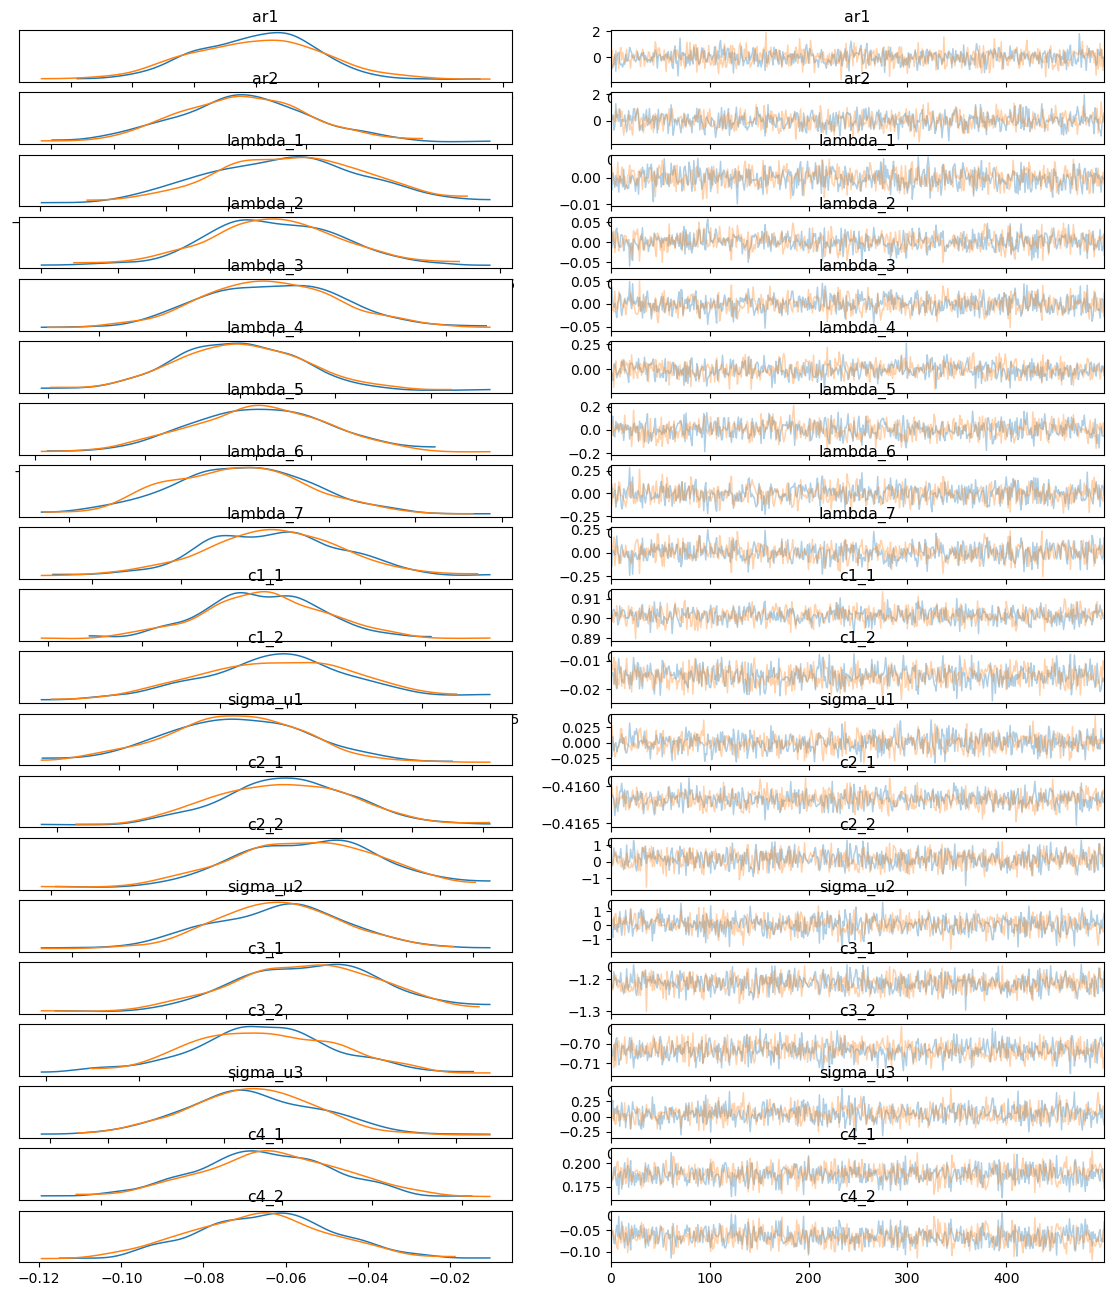

In [60]:
az.plot_trace(
    idata,
    var_names=var_names_list,
    figsize=(14, 16),
    compact=False
)

In [61]:
az.summary(idata, var_names=var_names_list)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ar1,-0.000,0.511,-0.914,0.939,0.015,0.014,1131.0,1012.0,1.0
ar2,0.011,0.511,-0.930,0.970,0.017,0.010,933.0,1027.0,1.0
lambda_1,-0.000,0.003,-0.006,0.005,0.000,0.000,974.0,985.0,1.0
lambda_2,0.001,0.018,-0.032,0.036,0.001,0.000,931.0,877.0,1.0
lambda_3,-0.000,0.016,-0.027,0.032,0.001,0.000,876.0,940.0,1.0
lambda_4,-0.003,0.066,-0.125,0.116,0.002,0.002,950.0,743.0,1.0
lambda_5,0.004,0.063,-0.118,0.113,0.002,0.001,960.0,958.0,1.0
lambda_6,-0.003,0.082,-0.149,0.156,0.003,0.002,928.0,664.0,1.0
lambda_7,0.002,0.080,-0.152,0.149,0.003,0.002,861.0,870.0,1.0
c1_1,0.901,0.003,0.895,0.907,0.000,0.000,1026.0,695.0,1.0


array([[<Axes: title={'center': 'ar1'}>, <Axes: title={'center': 'ar2'}>,
        <Axes: title={'center': 'lambda_1'}>],
       [<Axes: title={'center': 'lambda_2'}>,
        <Axes: title={'center': 'lambda_3'}>,
        <Axes: title={'center': 'lambda_4'}>],
       [<Axes: title={'center': 'lambda_5'}>,
        <Axes: title={'center': 'lambda_6'}>,
        <Axes: title={'center': 'lambda_7'}>],
       [<Axes: title={'center': 'c1_1'}>,
        <Axes: title={'center': 'c1_2'}>,
        <Axes: title={'center': 'sigma_u1'}>],
       [<Axes: title={'center': 'c2_1'}>,
        <Axes: title={'center': 'c2_2'}>,
        <Axes: title={'center': 'sigma_u2'}>],
       [<Axes: title={'center': 'c3_1'}>,
        <Axes: title={'center': 'c3_2'}>,
        <Axes: title={'center': 'sigma_u3'}>],
       [<Axes: title={'center': 'c4_1'}>,
        <Axes: title={'center': 'c4_2'}>,
        <Axes: title={'center': 'sigma_u4'}>]], dtype=object)

array([[<Axes: title={'center': 'ar1'}>, <Axes: title={'center': 'ar2'}>,
        <Axes: title={'center': 'lambda_1'}>],
       [<Axes: title={'center': 'lambda_2'}>,
        <Axes: title={'center': 'lambda_3'}>,
        <Axes: title={'center': 'lambda_4'}>],
       [<Axes: title={'center': 'lambda_5'}>,
        <Axes: title={'center': 'lambda_6'}>,
        <Axes: title={'center': 'lambda_7'}>],
       [<Axes: title={'center': 'c1_1'}>,
        <Axes: title={'center': 'c1_2'}>,
        <Axes: title={'center': 'sigma_u1'}>],
       [<Axes: title={'center': 'c2_1'}>,
        <Axes: title={'center': 'c2_2'}>,
        <Axes: title={'center': 'sigma_u2'}>],
       [<Axes: title={'center': 'c3_1'}>,
        <Axes: title={'center': 'c3_2'}>,
        <Axes: title={'center': 'sigma_u3'}>],
       [<Axes: title={'center': 'c4_1'}>,
        <Axes: title={'center': 'c4_2'}>,
        <Axes: title={'center': 'sigma_u4'}>]], dtype=object)

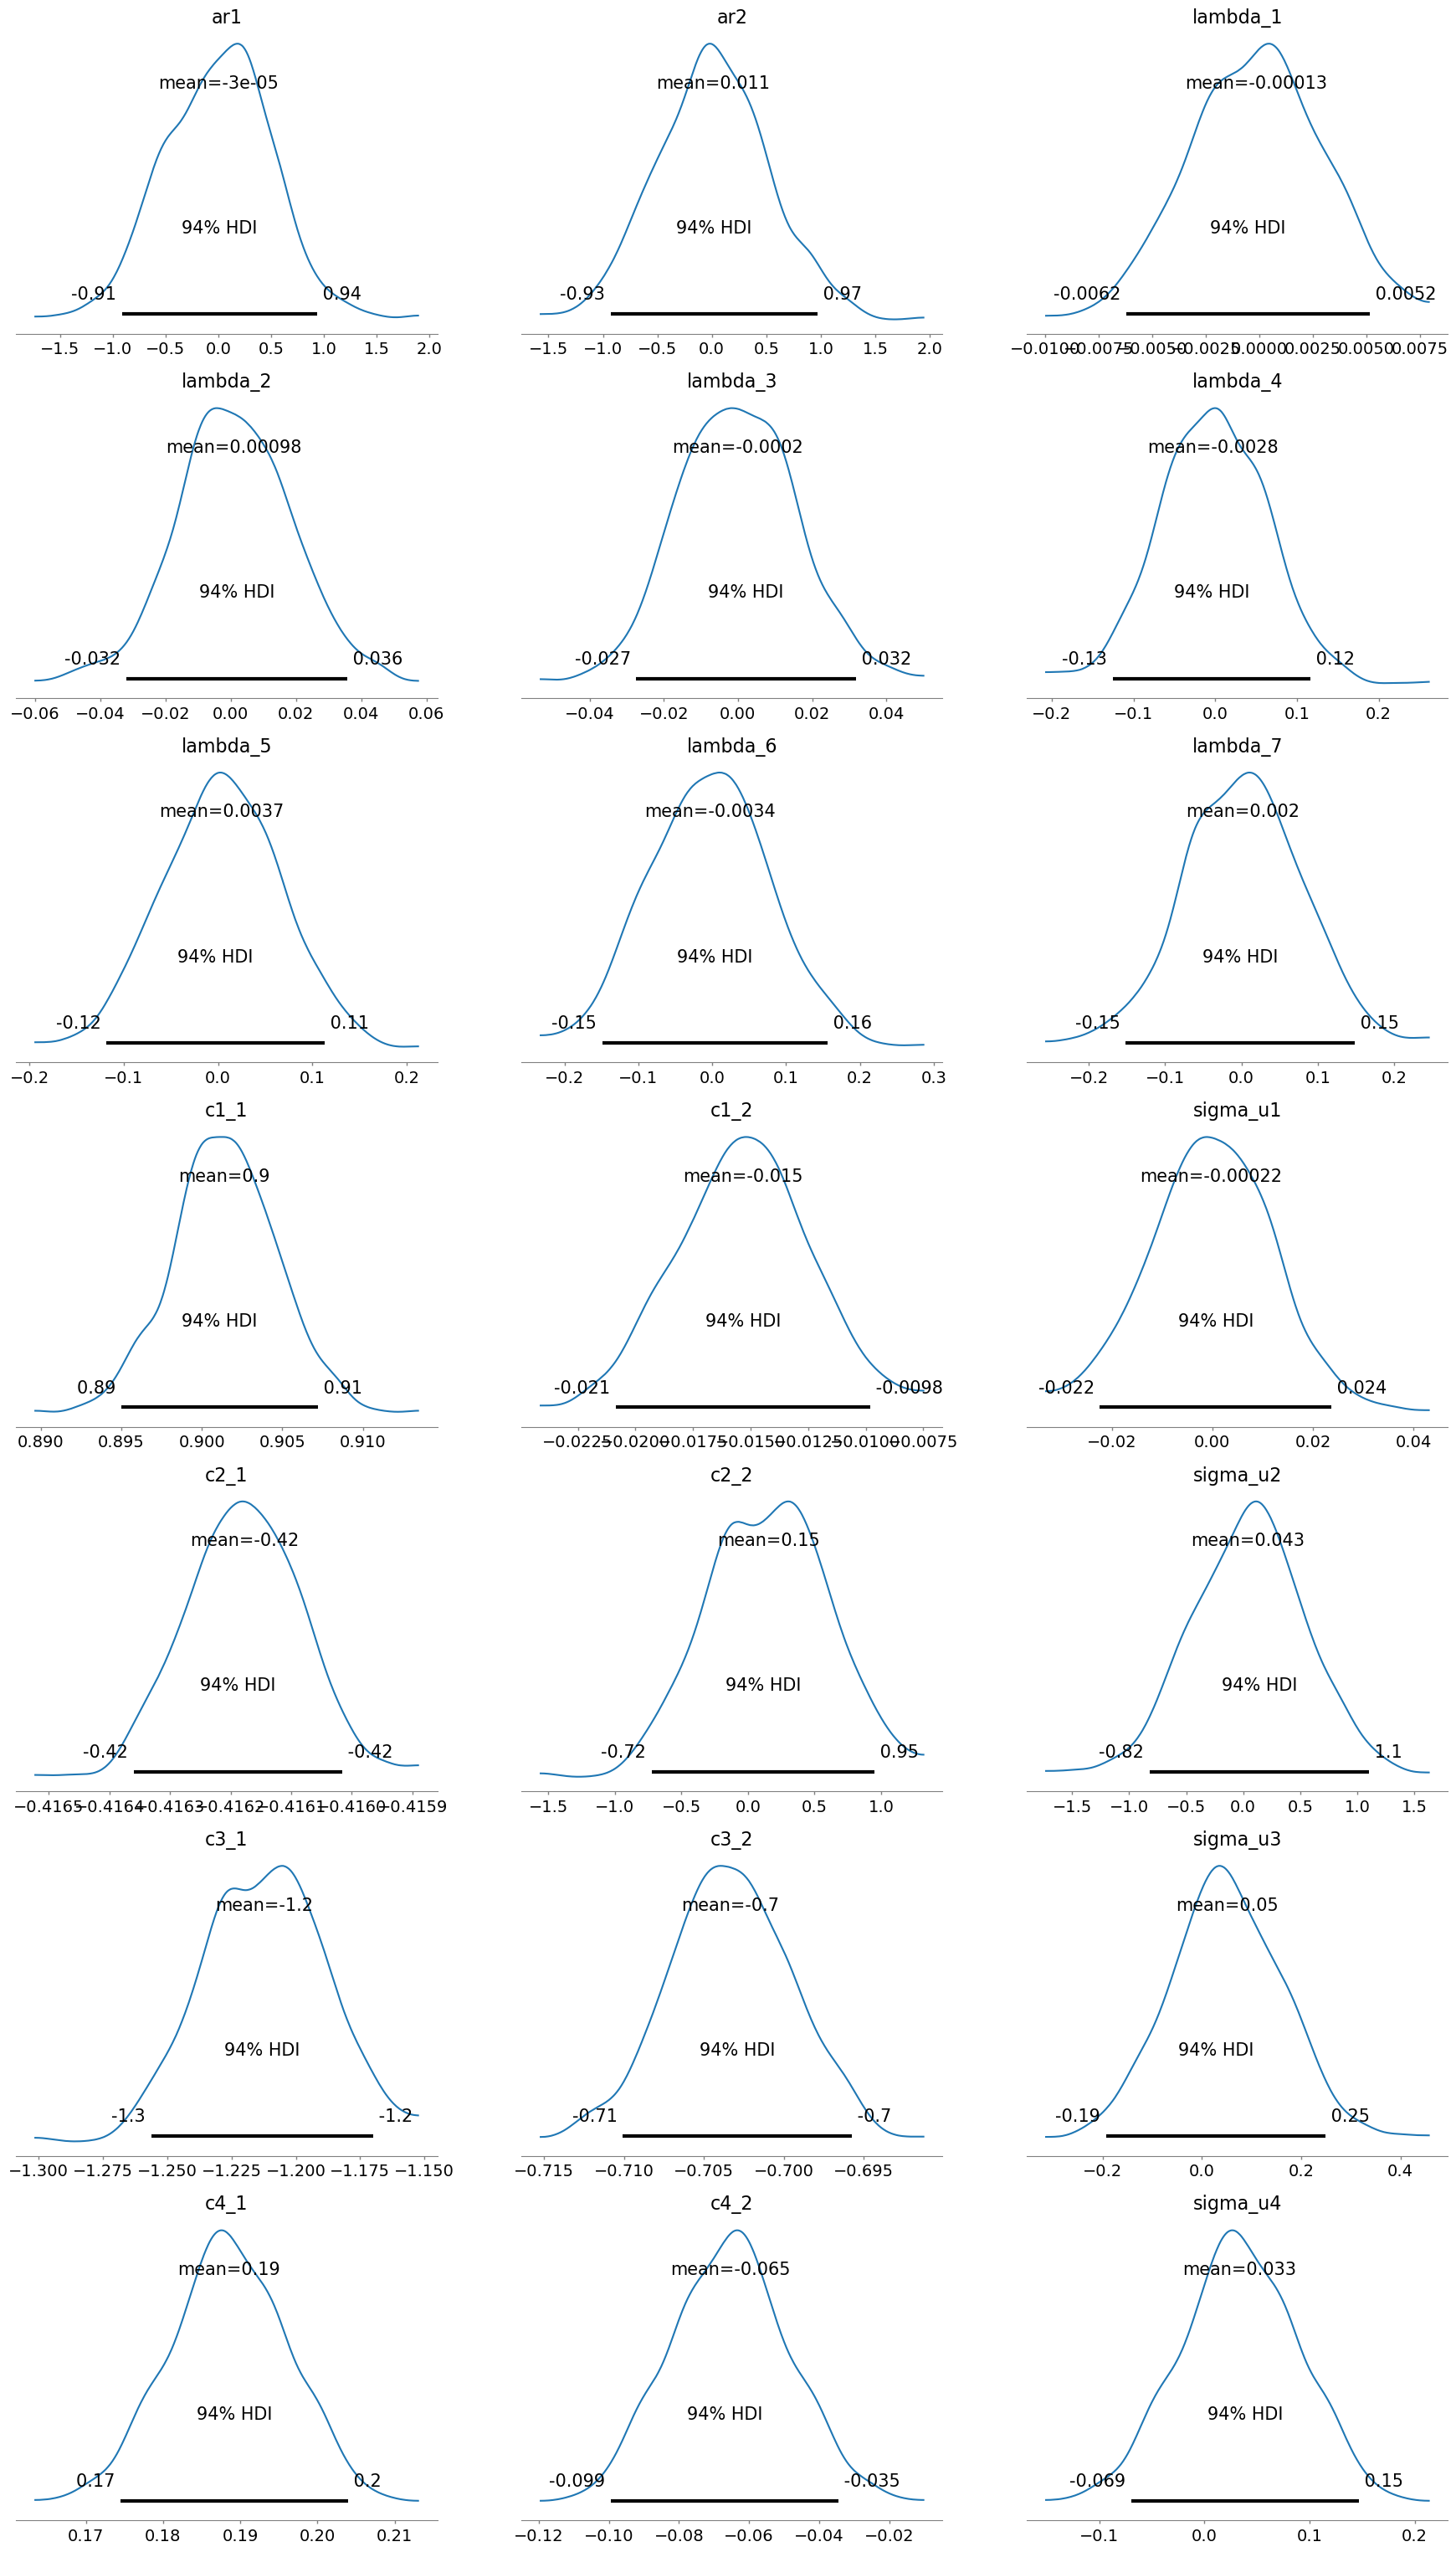

In [62]:
az.plot_posterior(
    idata,
    var_names=var_names_list,  
)

In [63]:
with pm.Model() as extended_index_mod:
    ext_coincident_dfm._build_dummy_graph()
    ext_coincident_dfm._insert_random_variables()
    x0, P0, C, D, T, Z, R, H, Q = matrices = ext_coincident_dfm.unpack_statespace()

    ext_coincident_dfm.build_statespace_graph(data=endog, mode="JAX", save_kalman_filter_outputs_in_idata=True)
    predicted_covariance = extended_index_mod["predicted_covariance"]
    filtered_state = extended_index_mod["filtered_state"]

    # attention to the order
    
    def step(P, Z, T, H):
        PZT = pt.dot(P, Z.T)

        F = pt.dot(Z, PZT) + H  # (4,4)
        F_reg = F + pt.eye(F.shape[0]) * 1e-6  # Add regularization
        K = pt.linalg.solve(F_reg.T, PZT.T).T 
        #F = Z.dot(PZT) + H + pt.eye(H.shape[0]) * 1e-2

        # K = pt.linalg.solve(F, pt.dot(T, PZT).T, assume_a="pos", check_finite=False).T   
        #K = pt.linalg.solve(F, PZT.T, assume_a="pos", check_finite=False).T
        return K

    ss_kalman_gain, updates = pytensor.scan(step, non_sequences=[Z, T, H], 
                                           sequences=[predicted_covariance])
    ss_kalman_gain = ss_kalman_gain[-1]  # Get the last Kalman gain (steady state)
    
    k_states = T.shape[0]

    W1 = pt.linalg.inv(
        pt.eye(k_states)
        - pt.dot(pt.eye(k_states) - pt.dot(ss_kalman_gain, Z), T)
    ).dot(ss_kalman_gain)[0]

    # Compute the factor mean vector
    factor_mean = pt.dot(W1, data.loc[start:, "dln_indprod":"dln_emp"].mean())
    print(factor_mean.shape)

    pm.Deterministic("factor_mean", factor_mean)
    factor_mean_idata=pm.sample_posterior_predictive(idata, var_names=["factor_mean"])
    filtered_state_idata = pm.sample_posterior_predictive(idata, var_names=["filtered_state"])

    



Shape.0


Shape.0


Sampling: []


Shape.0


Sampling: []


Output()

Sampling: []


Output()

In [64]:
def compute_coincident_index_pymc(factor_mean_idata, filtered_state_idata):

    # Extract posterior predictive samples
    factor_samples = factor_mean_idata.posterior_predictive["factor_mean"].values  
    factor_mean = factor_samples.mean(axis=(0, 1)) 


    # Extract posterior predictive samples
    state_samples = filtered_state_idata.posterior_predictive["filtered_state"].values  
    state_0_samples = state_samples[:, :, :, 0]  
    state_0_mean = state_0_samples.mean(axis=(0, 1))  


    # Normalize the states
    state_0_mean *= np.std(usphci.diff()[1:]) / np.std(state_0_mean)


    # Compute the coincident index
    coincident_index = np.zeros(state_0_mean.shape[0] + 1)
    print("Coincident index shape:", coincident_index.shape)
    # The initial value is arbitrary; here it is set to
    # facilitate comparison
    coincident_index[0] = usphci.iloc[0] * factor_mean / dusphci.mean()
    for t in range(0, state_0_mean.shape[0]):
        coincident_index[t + 1] = coincident_index[t] + state_0_mean[t] + factor_mean

    # Attach dates
    coincident_index = pd.Series(coincident_index, index=data.index).iloc[1:]

    # Normalize to use the same base year as USPHCI
    coincident_index *= usphci.loc["1992-07-01"] / coincident_index.loc["1992-07-01"]

    return coincident_index

Coincident index shape: (432,)


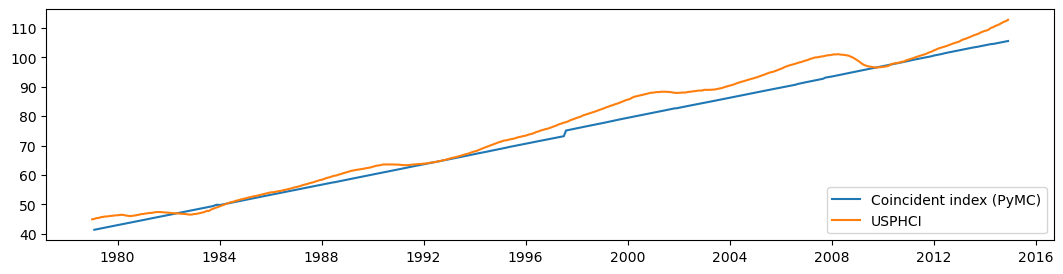

In [65]:
fig, ax = plt.subplots(figsize=(13, 3))

# Compute the index
coincident_index_pymc_ext = compute_coincident_index_pymc(factor_mean_idata, filtered_state_idata)

# Plot the factor
dates = endog.index._mpl_repr()
ax.plot(dates, coincident_index_pymc_ext, label="Coincident index (PyMC)")
ax.plot(usphci.index._mpl_repr(), usphci, label="USPHCI")
ax.legend(loc="lower right")



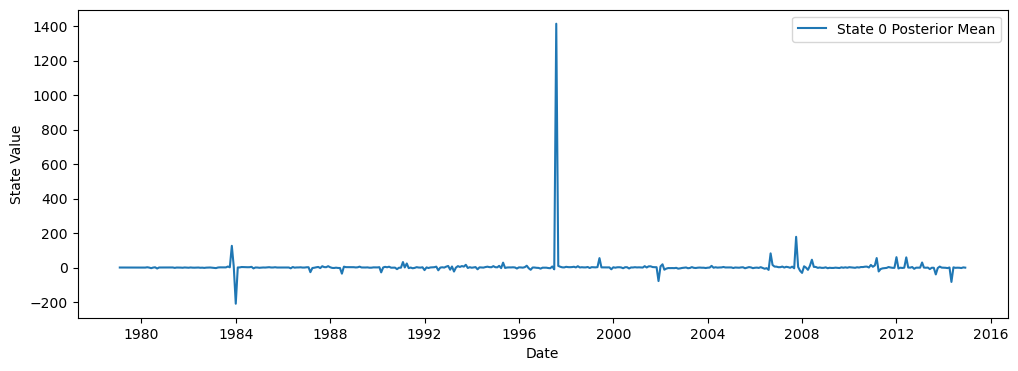

In [66]:
# Extract posterior predictive samples
state_samples = filtered_state_idata.posterior_predictive["filtered_state"].values  # shape: (2, 500, 10, 431)

# Select the first state (index 0)
state_0_samples_ext = state_samples[:, :, :, 0]  # shape: (1, 1000, 431)

# Average over chains and draws to get posterior mean for each time point
state_0_mean_ext = state_0_samples_ext.mean(axis=(0, 1))  # shape: (431,)

# Get the time index from your observed data for x-axis
dates = filtered_state_idata.observed_data.time.values  # array of datetime64

# Plot
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(dates, state_0_mean_ext, label="State 0 Posterior Mean")
ax.set_xlabel("Date")
ax.set_ylabel("State Value")
ax.legend()
plt.show()

lower = np.percentile(state_0_samples_ext, 2.5, axis=(0, 1))
upper = np.percentile(state_0_samples_ext, 97.5, axis=(0, 1))

ax.fill_between(dates, lower, upper, color='gray', alpha=0.3, label="95% CI")

## Comparison of Extended models

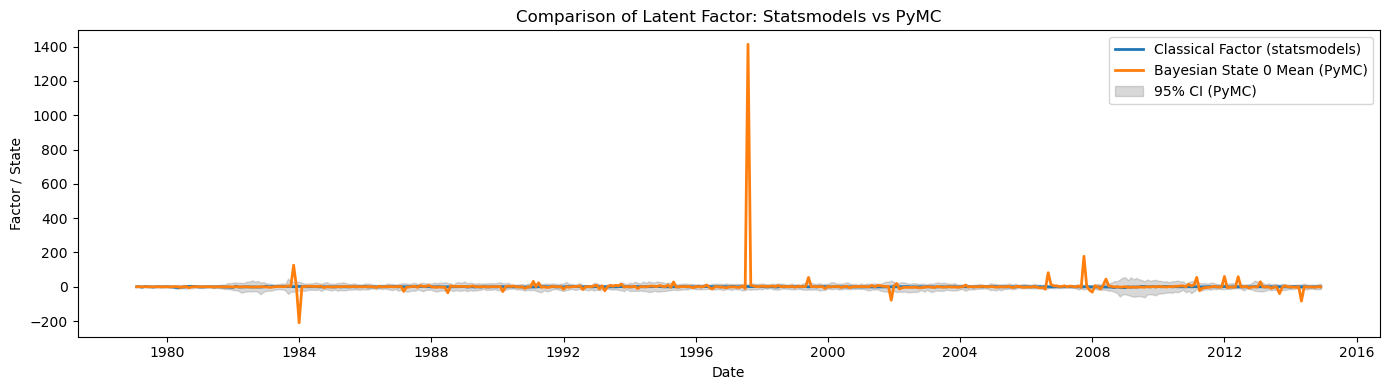

In [67]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(dates, -extended_res.factors.filtered[0], label="Classical Factor (statsmodels)", linewidth=2)
ax.plot(dates, state_0_mean_ext, label="Bayesian State 0 Mean (PyMC)", linewidth=2)
ax.fill_between(dates, lower, upper, color='gray', alpha=0.3, label="95% CI (PyMC)")
ax.legend()
ax.set_title("Comparison of Latent Factor: Statsmodels vs PyMC")
ax.set_xlabel("Date")
ax.set_ylabel("Factor / State")
plt.tight_layout()
plt.show()

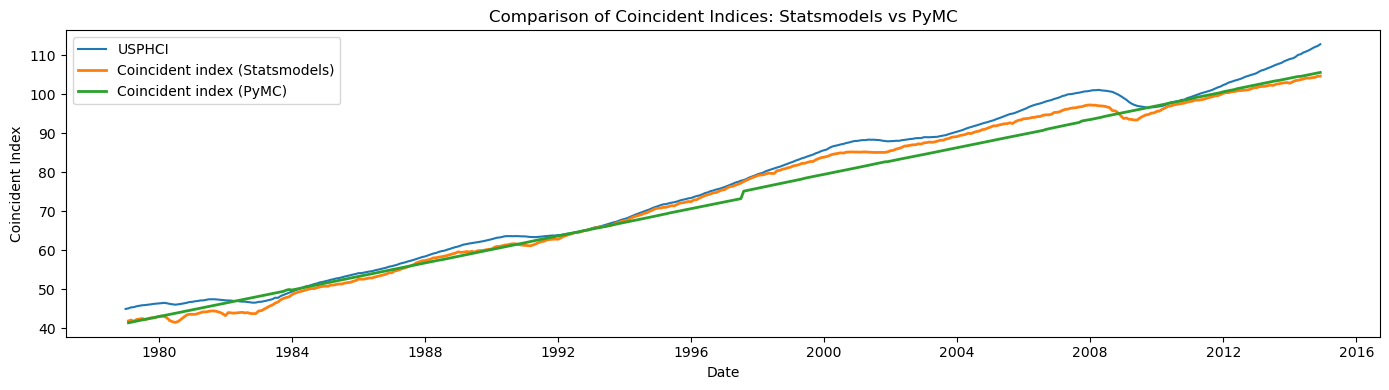

In [68]:

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(usphci.index._mpl_repr(), usphci, label="USPHCI")
ax.plot(dates, extended_coincident_index, label="Coincident index (Statsmodels)", linewidth=2)
ax.plot(dates, coincident_index_pymc_ext, label="Coincident index (PyMC)", linewidth=2)
ax.legend()
ax.set_title("Comparison of Coincident Indices: Statsmodels vs PyMC")
ax.set_xlabel("Date")
ax.set_ylabel("Coincident Index")
plt.tight_layout()
plt.show()